In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [26]:
df = pd.read_csv('FormattedData/GWW_formatted.csv', index_col = 0)
df.dropna(inplace = True)

In [27]:
def remove_corrs(df):
    
    corrs = df.corr().stack().reset_index()
    corrs.columns = ['1','2','R2']
    temp = corrs[(corrs.R2 > .8) & (corrs.R2 < .999)].sort_values('R2', ascending = False).reset_index(drop = True)
    correlations = temp[temp.index % 2 == 0]
    
    corr_index = correlations['1'].value_counts().index
    to_drop = round(len(corr_index)*.9)
    
    df2 = df.drop(corr_index[:to_drop], axis = 1)
    
    return df2

In [28]:
def preprocess_data(df):
    
    df.index = pd.to_datetime(df.index)
    
    X = df.shift(1).dropna()
    
    X_data = remove_corrs(X)
    
    y = df['adjustedclose'].iloc[1:]
    
    train_num = round(len(X)*.8)
    test_num = round(len(X)*.2)
    print(train_num, test_num)
    
    X_train = X_data.iloc[:train_num]
    X_test = X_data.iloc[-test_num:]
    y_train = y.iloc[:train_num]
    y_test = y.iloc[-test_num:]
    
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns).set_index(X_test.index)
    
    return X_train, X_test, y_train, y_test

In [29]:
X_train, X_test, y_train, y_test = preprocess_data(df)

1798 450


In [30]:
def EN_test(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'l1_ratio': [.01,.25,.5,.75,1],
    'alpha': [.01,.25,.5,.75,1],
    }
    
    # Instantiate & fit RidgeRegression
    en = ElasticNet(random_state = 42, max_iter = 10e5)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=en, param_grid=grid, cv=cv, scoring='neg_root_mean_squared_error', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_hat_train = gs.predict(X_train)
    y_hat_test = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv, scoring = 'neg_root_mean_squared_error')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)
    
    print(f'Train RMSE: {train_score}')
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    print(f'Test RMSE: {test_score}')

    preds_train = pd.concat([y_train, pd.DataFrame(y_hat_train, columns = ['predictions'], index = y_train.index), df.day_direction], axis = 1)
    preds_train.dropna(inplace = True)

    preds_train['direction'] = np.where(preds_train.predictions > preds_train.adjustedclose.shift(1), 1, 0)
    preds_train['correct'] = np.where(preds_train['direction'] == preds_train['day_direction'], 1, 0)
    train_accuracy = preds_train['correct'].value_counts(normalize = True)
    
    preds_test = pd.concat([y_test, pd.DataFrame(y_hat_test, columns = ['predictions'], index = y_test.index), df.day_direction], axis = 1)
    preds_test.dropna(inplace = True)

    preds_test['direction'] = np.where(preds_test.predictions > preds_test.adjustedclose.shift(1), 1, 0)
    preds_test['correct'] = np.where(preds_test['direction'] == preds_test['day_direction'], 1, 0)
    test_accuracy = preds_test['correct'].value_counts(normalize = True)

    print(f'Train accuracy: {train_accuracy[1]}')
    print(f'Test accuracy: {test_accuracy[1]}')
    
    results = ['elastic net', train_score, cv_results.mean(), test_score, train_accuracy[1], test_accuracy[1]]
    
    return results

In [31]:
en_results = EN_test(X_train,X_test,y_train,y_test)

Train RMSE: -25.37207247901399
Mean Cross-Val Score: -35.835940020819564
Test RMSE: -105.97096009516055
Train accuracy: 0.5116796440489433
Test accuracy: 0.45555555555555555


In [32]:
def SVR_test(X_train, X_test, y_train, y_test, cv=5):
    
    svr = LinearSVR(random_state = 42, max_iter = 10e5)
    svrmodel = svr.fit(X_train, y_train)
    
    train_score = svr.score(X_train, y_train)
    y_hat_train = svr.predict(X_train)
    train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
    train_cv_score = cross_val_score(svrmodel, X_train, y_train, scoring = 'neg_root_mean_squared_error').mean()
    
    test_score = svr.score(X_test, y_test)
    y_hat_test = svr.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)
    
    preds_train = pd.concat([y_train, pd.DataFrame(y_hat_train, columns = ['predictions'], index = y_train.index), df.day_direction], axis = 1)
    preds_train.dropna(inplace = True)

    preds_train['direction'] = np.where(preds_train.predictions > preds_train.adjustedclose.shift(1), 1, 0)
    preds_train['correct'] = np.where(preds_train['direction'] == preds_train['day_direction'], 1, 0)
    train_accuracy = preds_train['correct'].value_counts(normalize = True)
    
    preds_test = pd.concat([y_test, pd.DataFrame(y_hat_test, columns = ['predictions'], index = y_test.index), df.day_direction], axis = 1)
    preds_test.dropna(inplace = True)

    preds_test['direction'] = np.where(preds_test.predictions > preds_test.adjustedclose.shift(1), 1, 0)
    preds_test['correct'] = np.where(preds_test['direction'] == preds_test['day_direction'], 1, 0)
    test_accuracy = preds_test['correct'].value_counts(normalize = True)
    
    print(f'Train RMSE : {train_rmse}')
    print(f'Mean Train Cross-Validation RMSE: {train_cv_score}')
    print(f'Test RMSE : {test_rmse}')
    print(f'Train accuracy: {train_accuracy[1]}')
    print(f'Test accuracy: {test_accuracy[1]}')
 
    results = ['SVR', train_score, train_cv_score, test_score, train_accuracy[1], test_accuracy[1]]
    
    return results

In [33]:
svr_results = SVR_test(X_train, X_test, y_train, y_test)

Train RMSE : 63.25160381567274
Mean Train Cross-Validation RMSE: -51.851581513962174
Test RMSE : 124.4006624102215
Train accuracy: 0.503337041156841
Test accuracy: 0.4622222222222222


In [34]:
def Ridge_test(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
    'alpha': [.01, .05, .1,.5,.75,1],
    }
    
    # Instantiate & fit RidgeRegression
    ridge = Ridge(random_state = 42, max_iter = 10e5)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=ridge, param_grid=grid, cv=cv, scoring='r2', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    ridge_params = gs.best_params_
    
    # Create prediction variable using test data
    y_hat_train = gs.predict(X_train)
    y_hat_test = gs.predict(X_test)

    # Run cross-validate score with cv folds from function parameter
    train_cv_score = cross_val_score(gs, X_train, y_train, cv=cv, scoring = 'neg_root_mean_squared_error').mean()
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)

    train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
    test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)
    
    preds_train = pd.concat([y_train, pd.DataFrame(y_hat_train, columns = ['predictions'], index = y_train.index), df.day_direction], axis = 1)
    preds_train.dropna(inplace = True)

    preds_train['direction'] = np.where(preds_train.predictions > preds_train.adjustedclose.shift(1), 1, 0)
    preds_train['correct'] = np.where(preds_train['direction'] == preds_train['day_direction'], 1, 0)
    train_accuracy = preds_train['correct'].value_counts(normalize = True)
    
    preds_test = pd.concat([y_test, pd.DataFrame(y_hat_test, columns = ['predictions'], index = y_test.index), df.day_direction], axis = 1)
    preds_test.dropna(inplace = True)

    preds_test['direction'] = np.where(preds_test.predictions > preds_test.adjustedclose.shift(1), 1, 0)
    preds_test['correct'] = np.where(preds_test['direction'] == preds_test['day_direction'], 1, 0)
    test_accuracy = preds_test['correct'].value_counts(normalize = True)
    
    print(f'Train RMSE : {train_rmse}')
    print(f'Mean Train Cross-Validation RMSE: {train_cv_score}')
    print(f'Test RMSE : {test_rmse}')
    print(f'Train accuracy: {train_accuracy[1]}')
    print(f'Test accuracy: {test_accuracy[1]}')
 
    results = ['Ridge', train_rmse, train_cv_score, test_rmse, train_accuracy[1], test_accuracy[1]]
    
    return results

In [35]:
ridge_results = Ridge_test(X_train, X_test, y_train, y_test)

Train RMSE : 23.07423823941355
Mean Train Cross-Validation RMSE: -47.36874928812652
Test RMSE : 92.37237142358589
Train accuracy: 0.517797552836485
Test accuracy: 0.46


In [37]:
pd.DataFrame([en_results, svr_results, ridge_results],
            columns = ['Model Type', 'Train RMSE', 'Cross-Val RMSE', 'Test RMSE', 
             'Train Accuracy', 'Test Accuracy'])

,Model Type,Train RMSE,Cross-Val RMSE,Test RMSE,Train Accuracy,Test Accuracy
0,elastic net,-25.372072,-35.835940,-105.970960,0.511680,0.455556
1,SVR,-1.082459,-51.851582,-2.433871,0.503337,0.462222
2,Ridge,23.074238,-47.368749,92.372371,0.517798,0.460000


NameError: name 'y_hat_train' is not defined

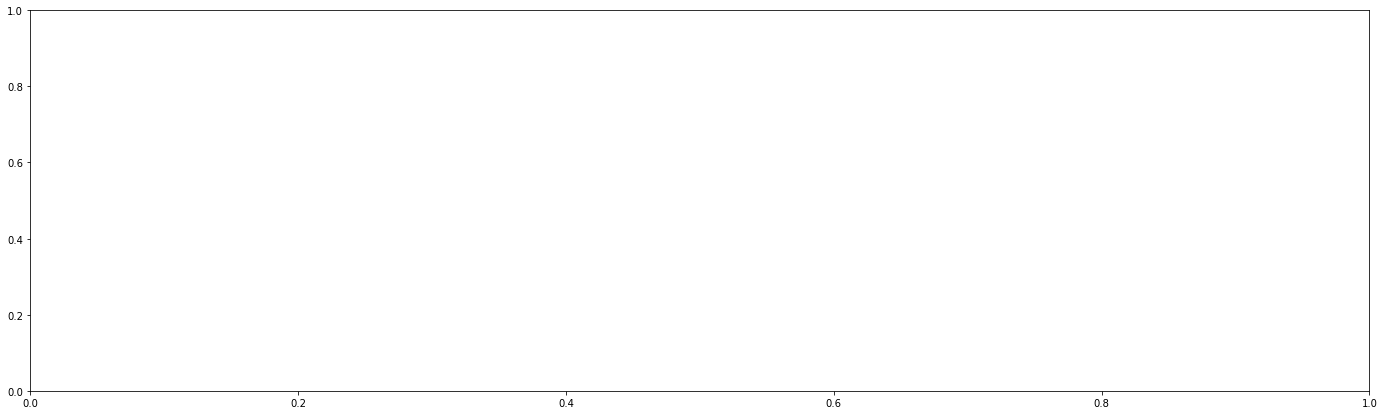

In [38]:
fig, ax = plt.subplots(figsize = (24,7))
plot_x = y_train.index
plot_y = (y_hat_train - y_train)/y_train
plt.scatter(plot_x,plot_y)
ax.yaxis.set_major_formatter('{x:1,.2%}')
plt.axhline(y=0, alpha = .5, color = 'red', linewidth = 4.0);

In [ ]:
fig2, ax = plt.subplots(figsize = (24,7))
ax.scatter(y_test.index, (y_hat_test - y_test)/y_test)
ax.yaxis.set_major_formatter('{x:1,.2%}')
plt.axhline(y=0, alpha = 1, color = 'red');

In [ ]:
fig3, ax = plt.subplots(figsize = (24,7))
fig3_data = preds_test[(preds_test.index >= '1-1-2020') & (preds_test.index <= '4-1-2021')]
ax.plot(fig3_data.adjustedclose, linewidth = 3.0)
ax.plot(fig3_data.predictions)
ax.yaxis.set_major_formatter('${x:1,.2f}');

In [ ]:
fig4, ax = plt.subplots(figsize = (24,7))
fig4_data = preds_train[(preds_train.index >= '1-1-2018') & (preds_train.index <= '1-1-2020')]
ax.plot(fig4_data.adjustedclose, linewidth = 3.0)
ax.plot(fig4_data.predictions)
ax.yaxis.set_major_formatter('${x:1,.2f}');

In [ ]:
#show prediction distance from previous close.